In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [7]:
df = pd.read_csv("houseprices.csv")
df = df.drop('Id', axis=1)
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [8]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), 
     make_column_selector(dtype_include='object')),
    remainder='passthrough'
)

transformed_data = transformer.fit_transform(df)

new_columns = transformer.get_feature_names_out()
df_encoded = pd.DataFrame(transformed_data, columns=new_columns)

In [9]:
df_encoded.head()

,onehotencoder__MSZoning_FV,onehotencoder__MSZoning_RH,onehotencoder__MSZoning_RL,onehotencoder__MSZoning_RM,onehotencoder__Street_Pave,onehotencoder__Alley_Pave,onehotencoder__Alley_nan,onehotencoder__LotShape_IR2,onehotencoder__LotShape_IR3,onehotencoder__LotShape_Reg,...,remainder__WoodDeckSF,remainder__OpenPorchSF,remainder__EnclosedPorch,remainder__3SsnPorch,remainder__ScreenPorch,remainder__PoolArea,remainder__MiscVal,remainder__MoSold,remainder__YrSold,remainder__SalePrice
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


In [10]:
obj_cols = df.select_dtypes(include=['object', 'string']).columns
df = pd.concat([df.drop(columns=obj_cols), df_encoded], axis=1)

In [11]:
df[df.select_dtypes("number").columns] = SimpleImputer(strategy="most_frequent").fit_transform(df.select_dtypes("number"))

<Axes: >

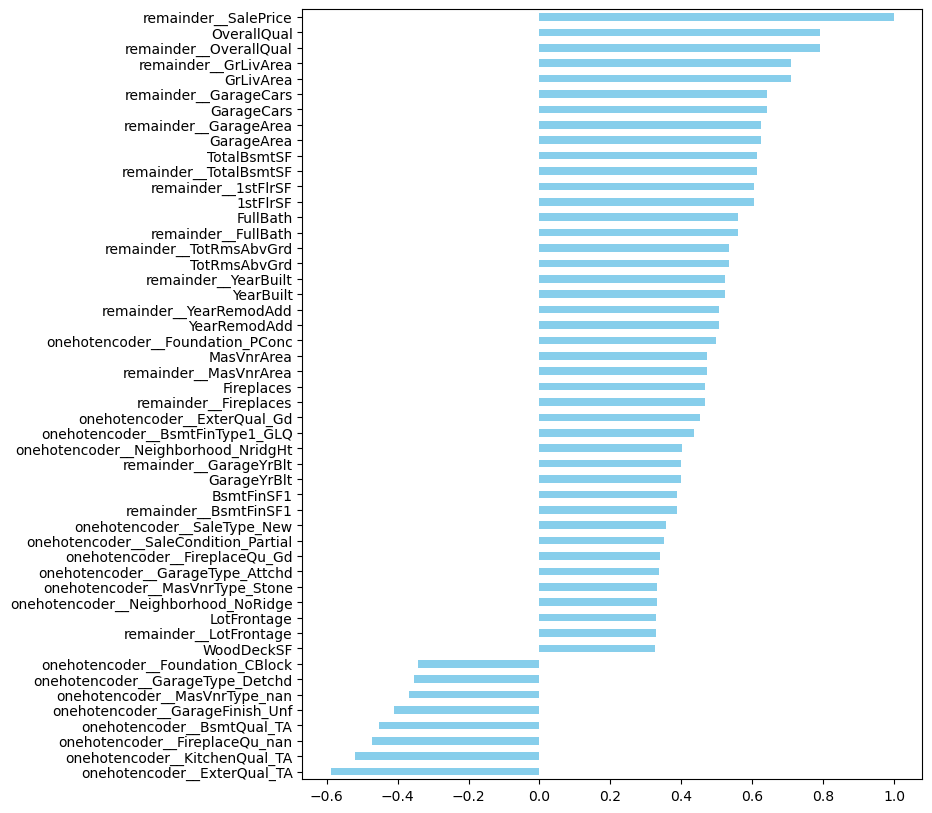

In [12]:
corr = df.corr(numeric_only=True)['SalePrice'].drop('SalePrice')

top_labels = corr.abs().sort_values(ascending=False).head(50).index

top_corr = corr[top_labels].sort_values()

top_corr.plot(kind="barh", figsize=(8, 10), color='skyblue')

In [14]:
y = np.array(df['SalePrice'])
X = df.drop(columns=['SalePrice'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
regr = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=5, learning_rate=0.01, loss="squared_error", random_state=42)

regr.fit(X_train_scaled, y_train)

y_pred = regr.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error (RMSE):", rmse)
print("Overall score:", regr.score(X_test_scaled, y_test))

Root Mean Square Error (RMSE): 7896.95363856127
Overall score: 0.9918697229967673
